# HW_8

1. Get dataset from Kaggle (any tabular dataset you want)
2. Make simple classifier / regressor on the dataset
3. Reasonably reduce dataset dimensionality
    * Plot explained variance
    * Explain chosen number of components
4. Retrain the same classifier / regressor on the dataset with reduced dimensionality
5. Compare accuracies / MSEs and speed of the two approaches (with and without dimensionality reduction)


## **1. Get dataset from Kaggle (any tabular dataset you want)**

Выполняем импорт необходимых библиотек, присваиваем общепринятые алиасы


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve

Считываем табличный датасет из файла .cvs
Создаем датафрейм и просматриваем первые 5 строк (по-умолчанию) кода данных

In [33]:
df = pd.read_csv('athens_weekdays.csv')
df.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,129.824479,Entire home/apt,False,False,4.0,False,0,0,10.0,100.0,2,2.813964,0.881890,55.348572,2.086871,78.778377,5.915160,23.76600,37.98300
1,1,138.963748,Entire home/apt,False,False,4.0,True,1,0,10.0,96.0,1,0.407293,0.304568,240.306654,9.060559,407.167696,30.572629,23.73168,37.97776
2,2,156.304923,Entire home/apt,False,False,3.0,True,0,1,10.0,98.0,1,1.237211,0.288488,199.507366,7.522257,395.967403,29.731642,23.72200,37.97900
3,3,91.627024,Entire home/apt,False,False,4.0,True,1,0,10.0,99.0,1,4.367457,0.297467,39.803047,1.500740,58.706578,4.408047,23.72712,38.01435
4,4,74.051508,Private room,False,True,2.0,False,0,0,10.0,100.0,1,2.194185,0.385266,78.733405,2.968577,113.325973,8.509204,23.73391,37.99529


Преобразуем тесктовые данные из столбца room_type в категории.
Преобразуем будевые значения в числовой тип данных из столбцов room_shared, room_private, host_is_superhost
Просмотр результата.

In [34]:
df['room_type'] = pd.Categorical(df.room_type).codes
df['room_shared'] = df.room_shared.astype(int)
df['room_private'] = df.room_private.astype(int)
df['host_is_superhost'] = df.host_is_superhost.astype(int)

df.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,129.824479,0,0,0,4.0,0,0,0,10.0,100.0,2,2.813964,0.881890,55.348572,2.086871,78.778377,5.915160,23.76600,37.98300
1,1,138.963748,0,0,0,4.0,1,1,0,10.0,96.0,1,0.407293,0.304568,240.306654,9.060559,407.167696,30.572629,23.73168,37.97776
2,2,156.304923,0,0,0,3.0,1,0,1,10.0,98.0,1,1.237211,0.288488,199.507366,7.522257,395.967403,29.731642,23.72200,37.97900
3,3,91.627024,0,0,0,4.0,1,1,0,10.0,99.0,1,4.367457,0.297467,39.803047,1.500740,58.706578,4.408047,23.72712,38.01435
4,4,74.051508,1,0,1,2.0,0,0,0,10.0,100.0,1,2.194185,0.385266,78.733405,2.968577,113.325973,8.509204,23.73391,37.99529


Вывод информации о датафрейме. Проверка на отсутствие пустых ячеек в таблице.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 0 to 2652
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  2653 non-null   int64  
 1   realSum                     2653 non-null   float64
 2   room_type                   2653 non-null   int8   
 3   room_shared                 2653 non-null   int32  
 4   room_private                2653 non-null   int32  
 5   person_capacity             2653 non-null   float64
 6   host_is_superhost           2653 non-null   int32  
 7   multi                       2653 non-null   int64  
 8   biz                         2653 non-null   int64  
 9   cleanliness_rating          2653 non-null   float64
 10  guest_satisfaction_overall  2653 non-null   float64
 11  bedrooms                    2653 non-null   int64  
 12  dist                        2653 non-null   float64
 13  metro_dist                  2653 

## **2. Make simple classifier / regressor on the dataset**

Выполняем импорт SGDClassifier, LogisticRegressionCV из скайлёрна

In [36]:
import time

from sklearn.linear_model import SGDClassifier

lr_sgdc = SGDClassifier()

Формируем данные для X_room, y_room. Исключаем из данных по X столбец с id 'Unnamed: 0', а так же 'room_type'

In [37]:
X_room = df.drop(['Unnamed: 0', 'room_type'], axis=1).values
X_room.shape

(2653, 18)

In [38]:
y_room = df['room_type'].values
y_room.shape

(2653,)

Импортируем train_test_split для формирования выборки для этапа обучения и этапа тестирования
Импортируем оценщики точности roc_auc_score, accuracy_score
Формируем выборки для этапа обучения и этапа тестирования (30%)

In [39]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_room, y_room, test_size=0.3)

Добавление функции построения графика кривой обучения MSE (источник: http://scikit-learn.org)

In [40]:
# Источник: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), part_name_fig=''):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Train примеры")
    plt.ylabel("Mean Squared Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Train MSE")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="C-V MSE")

    plt.legend(loc="best")
    plt.savefig(f"{part_name_fig} MSE.png")
    return plt

Обучение модели классификатора с стохастическим градиентным спуском

In [41]:
t1 = time.time()
lr_sgdc.fit(x_train, y_train)
t2 = time.time()
delta_t_x_train = t2 - t1
print(f'Затраченное время на обучение модели: {delta_t_x_train} сек.')

Затраченное время на обучение модели: 0.02499866485595703 сек.


Показатель точности (accuracy_score)

In [42]:
accuracy_x_test = lr_sgdc.score(x_test, y_test)
print(f'Показатель точности: {accuracy_x_test}')

Показатель точности: 0.9309045226130653


MSE для тренировочного датасета и тестового

In [43]:
train_mse = mean_squared_error(y_train, lr_sgdc.predict(x_train))
test_mse = mean_squared_error(y_test, lr_sgdc.predict(x_test))
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Train MSE: 0.0990845449649973
Test MSE: 0.07663316582914573


Построение графика кривой обучения MSE для lr_sgdc

E:\Python\PycharmProjects\PythonML\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


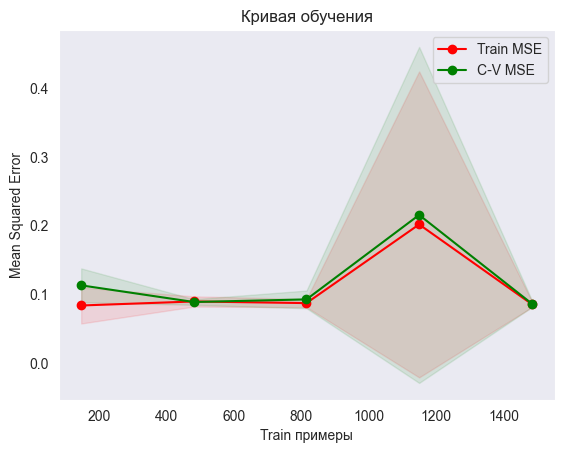

In [44]:
plot_learning_curve(lr_sgdc,
                    "Кривая обучения",
                    x_train,
                    y_train,
                    cv=5,
                    n_jobs=4,
                    part_name_fig='x_train');

## **3.Reasonably reduce dataset dimensionality**

* Plot explained variance
* Explain chosen number of components

Импортируем PCA (Principal Component Analysis (Метод главных компонентов)).
PCA метод позволит уменьшить размерность данных, потеряв наименьшее количество информации

In [45]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train)

PCA()

Вычисление кумулятивной суммы.
Построение графика пояснения дисперсии (explained variance) для всех компонентов.

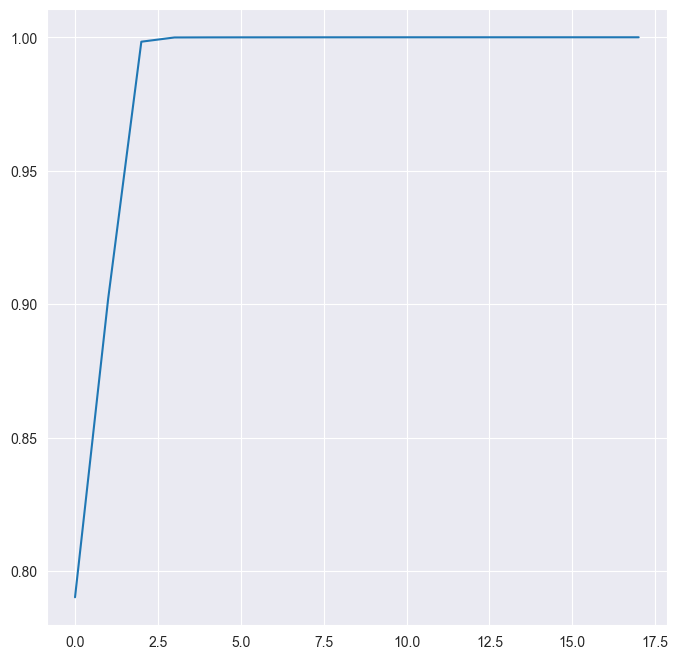

In [46]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 8))
plt.plot(cumsum)

На графике видно, что для обучения моделей классификации без значимых потерь данных достаточно 3 компонента.
Получение уточненного количества необходимых компонентов для пояснения дисперсии значений 0,99 и 0,97 соответственно

In [47]:
x_pca = PCA(n_components=0.999).fit_transform(x_train)
x_pca.shape

(1857, 4)

In [48]:
x_pca = PCA(n_components=0.97).fit_transform(x_train)
x_pca.shape

(1857, 3)

Построение графика для визуализации уменьшения размерности датасета.

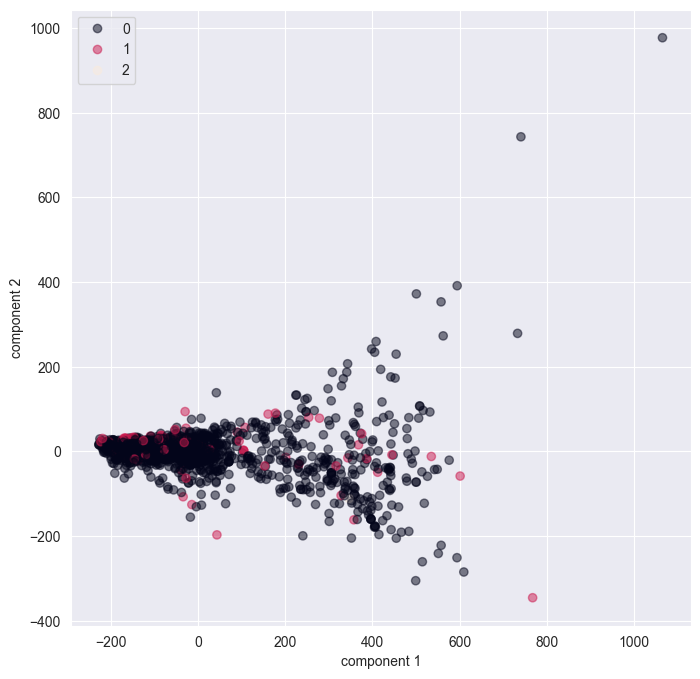

In [49]:
plt.figure(figsize=(8,8))
fig = plt.scatter(
    x_pca[:, 0][:1500],
    x_pca[:, 1][:1500],
    c=y_train[:1500],
    alpha=0.5
)
plt.xlabel('component 1')
plt.ylabel('component 2')
labels = list(map(str, range(20)))
plt.legend(handles=fig.legend_elements()[0], labels=labels)

plt.grid(True)

На визуализации можно наблюдать наложение групп компонентов, при изменении прозрачности группы относительно различимые друг от друга.

Построение графика с применением нелинейного алгоритма TSNE, UMAP (Uniform Manifold Approximation and Projection) для визуального сравнения.

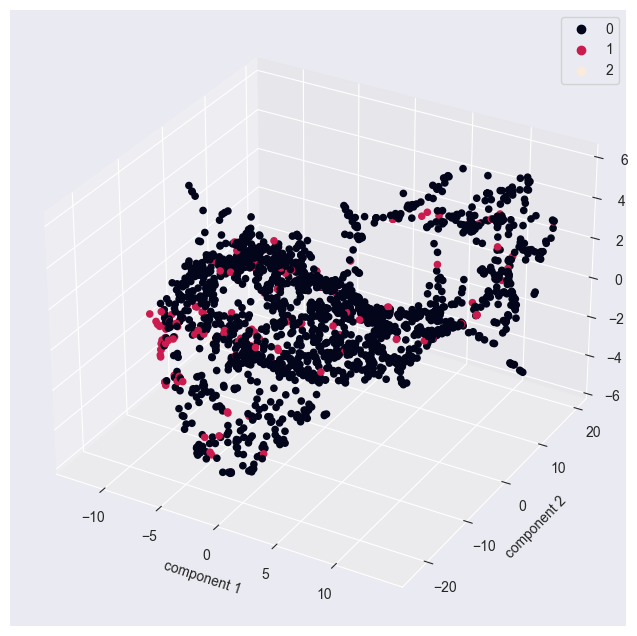

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)
X_room_tsne = tsne.fit_transform(x_train)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax = ax.scatter(
    X_room_tsne[:, 0][:],
    X_room_tsne[:, 1][:],
    X_room_tsne[:, 2][:],
    c=y_train[:], alpha=1,
)
plt.xlabel('component 1')
plt.ylabel('component 2')
labels = list(map(str, range(20)))
plt.legend(handles=ax.legend_elements()[0], labels=labels)

plt.grid(True)

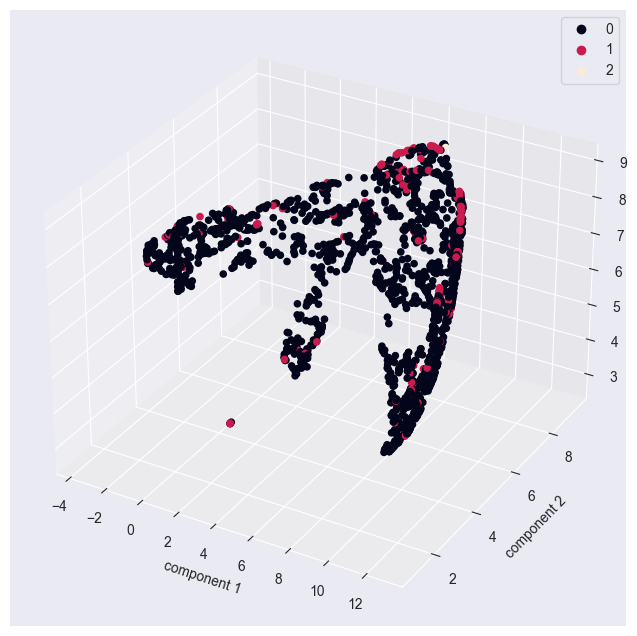

In [20]:
from umap import UMAP

umap_ = UMAP(n_components=3, random_state=42)
x_umap = umap_.fit_transform(x_train)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax = ax.scatter(
    x_umap[:, 0][:],
    x_umap[:, 1][:],
    x_umap[:, 2][:],
    c=y_train[:], alpha=1,
)
plt.xlabel('component 1')
plt.ylabel('component 2')
labels = list(map(str, range(20)))
plt.legend(handles=ax.legend_elements()[0], labels=labels)

plt.grid(True)

## **4. Retrain the same classifier / regressor on the dataset with reduced dimensionality**


Принимаем количество компонентов равное 2, что соответствует 0,97 пояснения дисперсии значений.
Переобучение модели классификатора с стохастическим градиентным спуском с уменьшенной размерностью.

In [21]:
pca = PCA(n_components=2)
x_pca_new = pca.fit_transform(x_train)
x_pca_pred = pca.transform(x_test)

lr_sgdc = SGDClassifier()

t1 = time.time()
lr_sgdc.fit(x_pca_new, y_train)
t2 = time.time()
delta_t_x_pca_new = t2 - t1
print(f'Затраченное время на обучение модели: {delta_t_x_pca_new} сек.')

Затраченное время на обучение модели: 0.019988536834716797 сек.


Показатель точности (accuracy_score)

In [22]:
accuracy_x_pca_pred = lr_sgdc.score(x_pca_pred, y_test)
print(f'Показатель точности: {accuracy_x_pca_pred}')

Показатель точности: 0.8115577889447236


## 5.Compare accuracies / MSEs and speed of the two approaches (with and without dimensionality reduction)

##### Как видно из проведенных экспериментов, обучение модели без уменьшения размерности занимает больше времени, но показатель точности при этом выше, среднеквадратичная ошибка ниже, чем после уменьшения. На более крупном датасете будет более заметна разница в значениях, после уменьшения размерности мы значительно сокращаем время, затраченное на обучение модели, но при этом "жертвуем" показателем точности. Если это не критично для эксперимента, то такой подход будет более актуален.

In [23]:
print('Без уменьшения размерности:')
print(f'\tЗатраченное время на обучение модели: {delta_t_x_train} сек.\n\tПоказатель точности: {accuracy_x_test}')
print('После уменьшения размерности:')
print(f'\tЗатраченное время на обучение модели: {delta_t_x_pca_new} сек.\n\tПоказатель точности: {accuracy_x_pca_pred}')

Без уменьшения размерности:
	Затраченное время на обучение модели: 0.013998270034790039 сек.
	Показатель точности: 0.8530150753768844
После уменьшения размерности:
	Затраченное время на обучение модели: 0.019988536834716797 сек.
	Показатель точности: 0.8115577889447236


##### Что касается кривой обучения loss MSE, то на графике видно, что на схождении линий значимого негативного эффекта не наблюдается, что позволляет сделать вывод, что после уменьшения данных, мы потеряли не значительно количество данных, но, как следствие, показатель MSE при этом увеличился.

MSE для тренировочного датасета и тестового

In [24]:
train_mse = mean_squared_error(y_train, lr_sgdc.predict(x_pca_new))
test_mse = mean_squared_error(y_test, lr_sgdc.predict(x_pca_pred))
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Train MSE: 0.4168012924071082
Test MSE: 0.5314070351758794


Построение графика кривой обучения MSE для lr_sgdc после переобучения

E:\Python\PycharmProjects\PythonML\venv\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


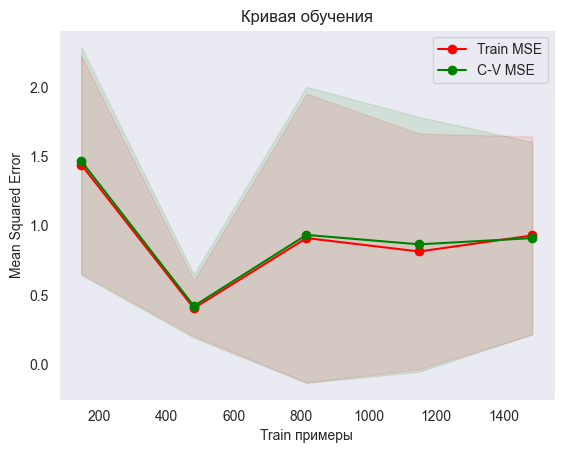

In [25]:
plot_learning_curve(lr_sgdc,
                    "Кривая обучения",
                    x_pca_new,
                    y_train,
                    cv=5,
                    n_jobs=4,
                    part_name_fig='x_pca');